# **I used data from Traced PI folder which included 116 images. In this first experiment I tried to predict the segmentation area using the traced images as our input.**

This might not be too practical in real life as someone else has already traced the images. Nevertheless, there might be some situations when we just need to trace the borders of images and segment the area using a deep learning model instead of spending hours trying to manually segment. In a second experiment I tried to predict the label maps using the original untraced data.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
from PIL import Image
import shutil
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from pathlib import Path
from torcheval.metrics import MulticlassAccuracy

device = "cuda" if torch.cuda.is_available() else "cpu"

'cuda'

# **Since the contours for the tracings were different: green, blue, and white. Using the HSV (Hue, Saturation, and value) in cv2 I first identified the contours based on color and saved each contour in a different file.**

I searched the Hue values for different colors from the internet. However there was a problem:

The hue for blue color ranges from 100 to 130, however if we set it to this range, several blue whole heart contours will not be segmented. In close inspection of some of the images, it is evident that blue contour is not completely drawn for some slices. However, in the parts where blue line is missing the red and green lines are visible which approximate the contour for the blue line. Afterall, We want to segment the whole heart using the blue line! In addition there are not a lot of slices like this, so it almost shouldnt affect model performance at all. Therefore by setting this  range to 0 to 180 we include all color hues. The Problem is Solved!!!!

In the next step where we fill in the contours it wont matter if our blue contours had green and red included.



In [ ]:
# Define the directory containing the images
image_directory = '/content/drive/MyDrive/ColabNotebooks/MRI/Source/'
# Define the directories to save the outcomes
green_directory = '/content/drive/MyDrive/ColabNotebooks/MRI/green/'
red_directory = '/content/drive/MyDrive/ColabNotebooks/MRI/red/'
blue_directory = '/content/drive/MyDrive/ColabNotebooks/MRI/blue/'


# Loop over all files in the image directory
for filename in os.listdir(image_directory):
    if filename.endswith('.jpg'):  # Check for .jpg files
        # Lets looad the image first
        image = cv2.imread(os.path.join(image_directory, filename))

        # Convert to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Define HSV ranges for green, red, and blue
        lower_green = np.array([40, 50, 50])
        upper_green = np.array([80, 255, 255])

        lower_red1 = np.array([0, 50, 50])
        upper_red1 = np.array([10, 255, 255])

        lower_red2 = np.array([170, 50, 50])
        upper_red2 = np.array([180, 255, 255])

        lower_blue = np.array([0, 50, 50])
        upper_blue = np.array([180, 255, 255])

        # lets create masks for each color
        mask_green = cv2.inRange(hsv, lower_green, upper_green)
        mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
        mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

        # find contours for each color
        contours_green, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_red1, _ = cv2.findContours(mask_red1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_red2, _ = cv2.findContours(mask_red2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_blue, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create blank binary images
        binary_green = np.zeros_like(image)
        binary_red = np.zeros_like(image)
        binary_blue = np.zeros_like(image)

        # Fill the binary images with the contours
        cv2.drawContours(binary_green, contours_green, -1, 255, thickness=cv2.FILLED)
        cv2.drawContours(binary_red, contours_red1 + contours_red2, -1, 255, thickness=cv2.FILLED)
        cv2.drawContours(binary_blue, contours_blue, -1, 255, thickness=cv2.FILLED)

        # Threshold the image to create binary images for each color
        _, binary_green = cv2.threshold(mask_green, 1, 255, cv2.THRESH_BINARY)
        _, binary_red1 = cv2.threshold(mask_red1, 1, 255, cv2.THRESH_BINARY)
        _, binary_red2 = cv2.threshold(mask_red2, 1, 255, cv2.THRESH_BINARY)
        _, binary_blue = cv2.threshold(mask_blue, 1, 255, cv2.THRESH_BINARY)

        # Lets combine the red masks into one
        binary_red = cv2.bitwise_or(binary_red1, binary_red2)

        # save the resulting binary images in their respective directories
        cv2.imwrite(os.path.join(green_directory, 'binary_green_' + filename), binary_green)
        cv2.imwrite(os.path.join(red_directory, 'binary_red_' + filename), binary_red)
        cv2.imwrite(os.path.join(blue_directory, 'binary_blue_' + filename), binary_blue)

        print(f"Processed {filename}")



Processed 7UK6AEPX_4Ch_7.jpg
Processed 7UK6AEPX_4Ch_46.jpg
Processed 7Z8559X2_4Ch_18.jpg
Processed 7Z8559X2_4Ch_34.jpg
Processed 8Q5ST993_4Ch_11.jpg
Processed 8Q5ST993_4Ch_38.jpg
Processed 64E586DT_4Ch_16.jpg
Processed 77QHA5DP_4Ch_0.jpg
Processed 77QHA5DP_4Ch_13.jpg
Processed AKJK98Q8_4Ch_38.jpg
Processed AKJK98Q8_4Ch_43.jpg
Processed BCENS63A_4Ch_34.jpg
Processed BCENS63A_4Ch_36.jpg
Processed 7F3ZSMCU_4Ch_32.jpg
Processed 7F3ZSMCU_4Ch_36.jpg
Processed 7F9JUJ2Z_4Ch_42.jpg
Processed 7F9JUJ2Z_4Ch_46.jpg
Processed 7F9XBDDM_4Ch_1.jpg
Processed 7F9XBDDM_4Ch_41.jpg
Processed 7F723YH3_4Ch_30.jpg
Processed 7F723YH3_4Ch_33.jpg
Processed 7PEU8P7N_4Ch_16.jpg
Processed 7PEU8P7N_4Ch_43.jpg
Processed 7ZCJU3KH_4Ch_36.jpg
Processed 7ZCJU3KH_4Ch_46.jpg
Processed 77ZKXBQJ_4Ch_14.jpg
Processed 77ZKXBQJ_4Ch_47.jpg
Processed 77ZVEQJZ_4Ch_6.jpg
Processed 77ZVEQJZ_4Ch_13.jpg
Processed 369C9APX_4Ch_13.jpg
Processed 369C9APX_4Ch_42.jpg
Processed 369JCPZD_4Ch_20.jpg
Processed 369JCPZD_4Ch_43.jpg
Processed 736K

# **Now we can fill in the contours in the different images.**

In [ ]:
# We will run this code 3 times, each time for one of the colors by just changing the directories
source_dir = '/content/drive/MyDrive/ColabNotebooks/MRI/blue/'
destination_dir = '/content/drive/MyDrive/ColabNotebooks/MRI/Blabels/'


# Process each image in the source directory
for filename in os.listdir(source_dir):
    if filename.endswith('.jpg'):  # Check for .jpg files
        # Read the image
        image_path = os.path.join(source_dir, filename)
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply threshold
        _, thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)

        # Find contours
        cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]

        # Draw contours on the original image and fill them
        for c in cnts:
            cv2.drawContours(image, [c], -1, (255,255,255), -1)

        # Save the processed image to the destination directory
        result_path = os.path.join(destination_dir, filename)
        cv2.imwrite(result_path, image)


# **Let's visualize what we have *now*.**

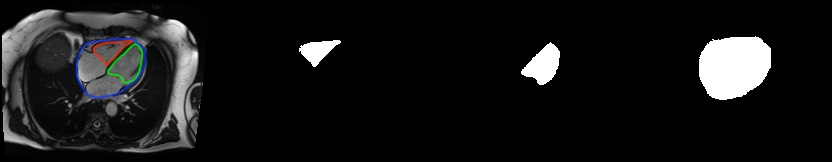

In [ ]:
# Lets Visualise one of the images:
image = cv2.imread('/content/drive/MyDrive/ColabNotebooks/MRI/Source/3692B7ES_4Ch_40.jpg')
image1 = cv2.imread('/content/drive/MyDrive/ColabNotebooks/MRI/Rlabels/binary_red_3692B7ES_4Ch_40.jpg')
image2 = cv2.imread('/content/drive/MyDrive/ColabNotebooks/MRI/Glabels/binary_green_3692B7ES_4Ch_40.jpg')
image3 = cv2.imread('/content/drive/MyDrive/ColabNotebooks/MRI/Blabels/binary_blue_3692B7ES_4Ch_40.jpg')

horizontal_concat = np.concatenate((image, image1, image2, image3), axis=1)
cv2_imshow(horizontal_concat)


# **So now that we have completed task 1 we move on to the best part! Training the deep learning model!**

First let's visualize what I wanted to do. We have 3 labels in 3 different files. I wanted to desing a multiclass segmentation model to identify all the masks (as in the picture). So I merged all the images and saved them in a numpy file with the following 4 labels (0=background, 1=whole heart, 2=left ventricle, 3=right ventricle).

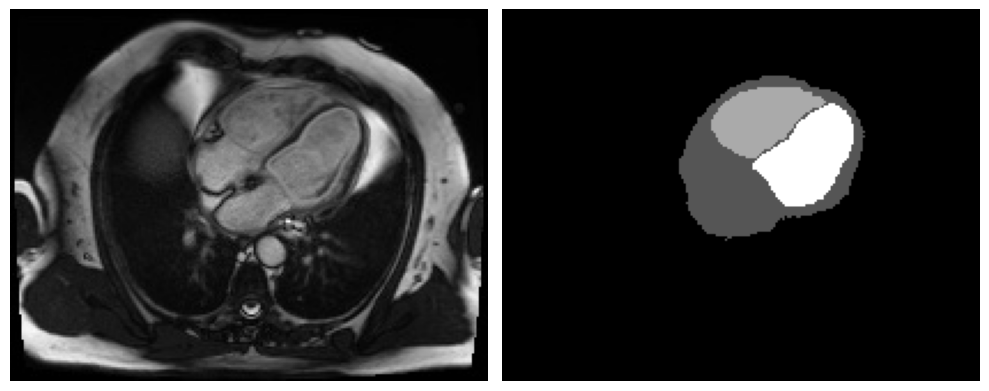

In [ ]:
#Let's visualize!
image1 = cv2.imread('/content/drive/MyDrive/ColabNotebooks/MRI/Blabels/binary_blue_7F9XBDDM_4Ch_1.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/drive/MyDrive/ColabNotebooks/MRI/Rlabels/binary_red_7F9XBDDM_4Ch_1.jpg', cv2.IMREAD_GRAYSCALE)
image3 = cv2.imread('/content/drive/MyDrive/ColabNotebooks/MRI/Glabels/binary_green_7F9XBDDM_4Ch_1.jpg', cv2.IMREAD_GRAYSCALE)
image4 = cv2.imread('/content/drive/MyDrive/ColabNotebooks/MRI/Source/7F9XBDDM_4Ch_1.jpg', cv2.IMREAD_GRAYSCALE)

# Normalize pixel values to [0, 1]
normalized_image1 = image1.astype(np.float32) / 255.0
normalized_image2 = image2.astype(np.float32) / 255.0
normalized_image3 = image3.astype(np.float32) / 255.0

new_arr1 = np.where(normalized_image1 > 0.3, 1, 0)
new_arr2 = np.where(normalized_image2 > 0.3, 2, 0)
new_arr3 = np.where(normalized_image3 > 0.3, 3, 0)

new_array = np.zeros_like(new_arr1)
new_array [new_arr1 == 1] = 1
new_array [new_arr2 == 2] = 2
new_array [new_arr3 == 3] = 3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(image4, cmap='gray')
ax1.axis('off')

ax2.imshow(new_array, cmap='gray')
ax2.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define the paths to the folders containing the images
blue_folder = '/content/drive/MyDrive/ColabNotebooks/MRI/Blabels/'
red_folder = '/content/drive/MyDrive/ColabNotebooks/MRI/Rlabels/'
green_folder = '/content/drive/MyDrive/ColabNotebooks/MRI/Glabels/'

# labels_folder is the final folder where I have put our segmentation masks. Each mask has 4 values from 0 to 3 each representing a segment.
labels_folder = '/content/drive/MyDrive/ColabNotebooks/MRI/labels/'

# Function to process images
def process_image(image_path, threshold, label_value):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    normalized_image = image.astype(np.float32) / 255.0
    return np.where(normalized_image > threshold, label_value, 0)

# Get the list of image filenames from the blue folder
image_filenames = [f for f in os.listdir(blue_folder) if f.startswith('binary_blue_')]

# Process each image
for filename in image_filenames:
    # Extract the common name part from the blue image filename
    common_name_part = filename[len('binary_blue_'):-len('.jpg')]  # Adjust the slicing according to the file extension

    # Construct the file paths for the red and green images using the common name part
    red_image_filename = f'binary_red_{common_name_part}.jpg'
    green_image_filename = f'binary_green_{common_name_part}.jpg'
    red_image_path = os.path.join(red_folder, red_image_filename)
    green_image_path = os.path.join(green_folder, green_image_filename)

    # Process the images
    blue_image_path = os.path.join(blue_folder, filename)
    new_arr1 = process_image(blue_image_path, 0.3, 1)
    new_arr2 = process_image(red_image_path, 0.3, 2)
    new_arr3 = process_image(green_image_path, 0.3, 3)

    # Combine the processed images into a single array
    new_array = np.zeros_like(new_arr1)
    new_array[new_arr1 == 1] = 1
    new_array[new_arr2 == 2] = 2
    new_array[new_arr3 == 3] = 3

    # Save the resulting numpy array to the labels folder with the same common name part
    output_path = os.path.join(labels_folder, f'{common_name_part}.npy')
    np.save(output_path, new_array)

# **Now we split the data into 4 folder: train labels, train data, test labels, and test data**

I used a random 80-20 split, however we can increase the training data if necessary


In [ ]:
# Paths to the source folders
Source = '/content/drive/MyDrive/ColabNotebooks/MRI/Source/'
labels = '/content/drive/MyDrive/ColabNotebooks/MRI/labels/'

# Paths to the destination folders
train_folder_data = '/content/drive/MyDrive/ColabNotebooks/MRI/train_folder_data/'
train_folder_labels = '/content/drive/MyDrive/ColabNotebooks/MRI/train_folder_labels/'
test_folder_data = '/content/drive/MyDrive/ColabNotebooks/MRI/test_folder_data/'
test_folder_labels = '/content/drive/MyDrive/ColabNotebooks/MRI/test_folder_labels/'


# Get a list of image names from the jpg folder
image_names = [filename for filename in os.listdir(Source) if filename.endswith('.jpg')]

# Shufle  the list of image names
np.random.shuffle(image_names)

# Split the list into 80% train and 20% test
split_index = int(0.8 * len(image_names))
train_images = image_names[:split_index]
test_images = image_names[split_index:]

# Function to copy images to the corresponding folder
def copy_files(images, source_folder_jpg, source_folder_npy, dest_folder_jpg, dest_folder_npy):
    for image_name in images:
        # Copy jpg files
        jpg_source_path = os.path.join(source_folder_jpg, image_name)
        jpg_destination_path = os.path.join(dest_folder_jpg, image_name)
        shutil.copy(jpg_source_path, jpg_destination_path)

        # Copy npy files
        npy_image_name = image_name.replace('.jpg', '.npy')
        npy_source_path = os.path.join(source_folder_npy, npy_image_name)
        npy_destination_path = os.path.join(dest_folder_npy, npy_image_name)
        shutil.copy(npy_source_path, npy_destination_path)

# Copy files to the corresponding train and test folders
copy_files(train_images, Source, labels, train_folder_data , train_folder_labels )
copy_files(test_images, Source, labels, test_folder_data , test_folder_labels)

print(f'Training images and npy files copied: {len(train_images)}')
print(f'Testing images and npy files copied: {len(test_images)}')

Training images and npy files copied: 92
Testing images and npy files copied: 24


# **Custom dataset, data loaders, and the model**

I normalized the images in this stage. In dataloaders I used batch sizes of 8 considering that a middle range number that can allow faster model convergene. However in an ideal world I would use cross-validation optimizing several models and hyperparameters including batch size, lr, and optimizer. Here 8 works fine considering we only have 116 pictures using a bigger or smaller batch size may hinder the accuracy.

In this project I did not use any augmentations as it was not necessary, however in the second project I used several random flips to see if it increases the accuracy.

In the custom data set I wrote the code step by step to be more explainable, however for faster performance and not going to and fro between processor and memory in the second project I wrote like this:

"" image = torch.from_numpy(cv2.resize(self.normalized_train[index], (256, 256))).unsqueeze(0).to(dtype=torch.float32)""

For models I used a smiple UNET structure with the motto: Simple tasks best fit with the simple models. I had resized all images to 256x256 which I think can align perfectly with UNet structure

In [ ]:
# Function to normalize an image
def normalize_image(image_path):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    normalized_img_array = img / 255.0
    return normalized_img_array

In [ ]:
# designing custom dataset
class MyCustomDataset(Dataset):
    def __init__(self, data, dataset_labels, data_transform=None, label_transform=None):
        self.data = data
        self.dataset_labels = dataset_labels
        self.data_transform = data_transform
        self.label_transform = label_transform
        # Normalize all images in the train and test data folders
        self.normalized_train = [normalize_image(os.path.join(data, filename))
                     for filename in os.listdir(data) if filename.endswith('.jpg')]

        self.paths= list(Path(dataset_labels).glob('*.npy'))

    def __len__(self):
        return len(self.normalized_train)

    def __getitem__(self, index):
        image = self.normalized_train[index]
        image = cv2.resize(image, (256, 256))
        image = torch.from_numpy(image).unsqueeze(0)
        image= image.to(dtype=torch.float32)

        dataset_labels = self.paths[index]
        dataset_labels = np.load(dataset_labels)
        dataset_labels = cv2.resize(np.uint8(dataset_labels), (256, 256))
        dataset_labels = torch.from_numpy(dataset_labels)
        dataset_labels = dataset_labels.to(dtype=torch.long)

        if self.data_transform:
            image = self.data_transform(image)

        if self.label_transform:
            dataset_labels = self.label_transform(dataset_labels)

        return image, dataset_labels

In [ ]:
train_folder_data = '/content/drive/MyDrive/ColabNotebooks/MRI/train_folder_data/'
train_folder_labels = '/content/drive/MyDrive/ColabNotebooks/MRI/train_folder_labels/'
test_folder_data = '/content/drive/MyDrive/ColabNotebooks/MRI/test_folder_data/'
test_folder_labels = '/content/drive/MyDrive/ColabNotebooks/MRI/test_folder_labels/'

train_dataset= MyCustomDataset (data= train_folder_data, dataset_labels = train_folder_labels, data_transform = None, label_transform = None )
test_dataset= MyCustomDataset (data=test_folder_data, dataset_labels = test_folder_labels, data_transform = None, label_transform = None )

In [ ]:
# Data loader
train_dataloader_custom = DataLoader(dataset=train_dataset,
                                     batch_size=8,
                                     num_workers=2,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_dataset,
                                    batch_size=8,
                                    num_workers=2,
                                    shuffle=False) # don't usually need to shuffle testing data

In [ ]:
class DoubleConv(torch.nn.Module):
    # Helper Class which implements the intermediate Convolutions
    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())

    def forward(self, X):
        return self.step(X)

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)

        self.layer5 = DoubleConv(512+256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 4, 1)

        self.maxpool = torch.nn.MaxPool2d(2)

    def forward(self, x):

        x1 = self.layer1(x)
        x1m = self.maxpool(x1)

        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)

        x4 = self.layer4(x3m)

        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)

        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)

        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)

        ret = self.layer8(x7)
        return ret

# **Here are the training and test functions. For model loss I used crossentropyloss from pythorch with lr=0.001 and ADAM optimizer. I trained over 40 epochs. Alternatively we can use DICE.**

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):

        # Send data to target device
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(y_pred, dim=1)
        corrects = (y_pred_class == y)
        train_acc += corrects.sum().item()/(torch.numel(corrects))


    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)



            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(test_pred_logits, dim=1).to(dtype=torch.float32)
            corrects = (test_pred_labels == y)
            test_acc += corrects.sum().item()/(torch.numel(corrects))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Let's Print out!!!!
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 40

# Recreate an instance of Unet
model= UNet().to(device)
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train (model=model,
                        train_dataloader=train_dataloader_custom,
                        test_dataloader=test_dataloader_custom,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7018 | train_acc: 0.7130 | test_loss: 0.9687 | test_acc: 0.8894
Epoch: 2 | train_loss: 0.4345 | train_acc: 0.8924 | test_loss: 0.2912 | test_acc: 0.8894
Epoch: 3 | train_loss: 0.2929 | train_acc: 0.8935 | test_loss: 0.2920 | test_acc: 0.8904
Epoch: 4 | train_loss: 0.2528 | train_acc: 0.8971 | test_loss: 0.2384 | test_acc: 0.9001
Epoch: 5 | train_loss: 0.2279 | train_acc: 0.9042 | test_loss: 0.2103 | test_acc: 0.9144
Epoch: 6 | train_loss: 0.1977 | train_acc: 0.9124 | test_loss: 0.1871 | test_acc: 0.9223
Epoch: 7 | train_loss: 0.1773 | train_acc: 0.9210 | test_loss: 0.1757 | test_acc: 0.9297
Epoch: 8 | train_loss: 0.1767 | train_acc: 0.9288 | test_loss: 0.2200 | test_acc: 0.9163
Epoch: 9 | train_loss: 0.1857 | train_acc: 0.9297 | test_loss: 0.1606 | test_acc: 0.9430
Epoch: 10 | train_loss: 0.1492 | train_acc: 0.9396 | test_loss: 0.1646 | test_acc: 0.9451
Epoch: 11 | train_loss: 0.1419 | train_acc: 0.9438 | test_loss: 0.1582 | test_acc: 0.9472
Epoch: 12 | train_l

# **Let's plot the loss and accuracy and evaluate the model. We can also use DICE or AUC. The test and train curves converged pretty good. The test accuracy reached 98%.**

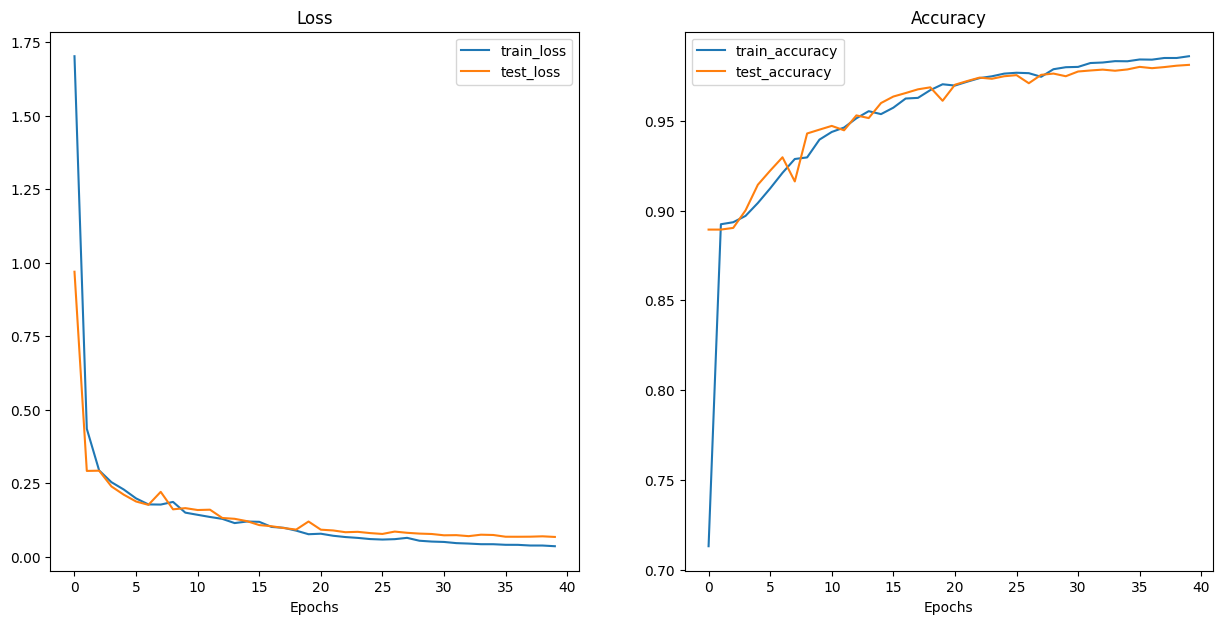

In [ ]:
def plot_loss_curves(results):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_0_results)

# **Let's visualise what the model is predicting and what we gave to it! Voila!! Looks pretty good.**

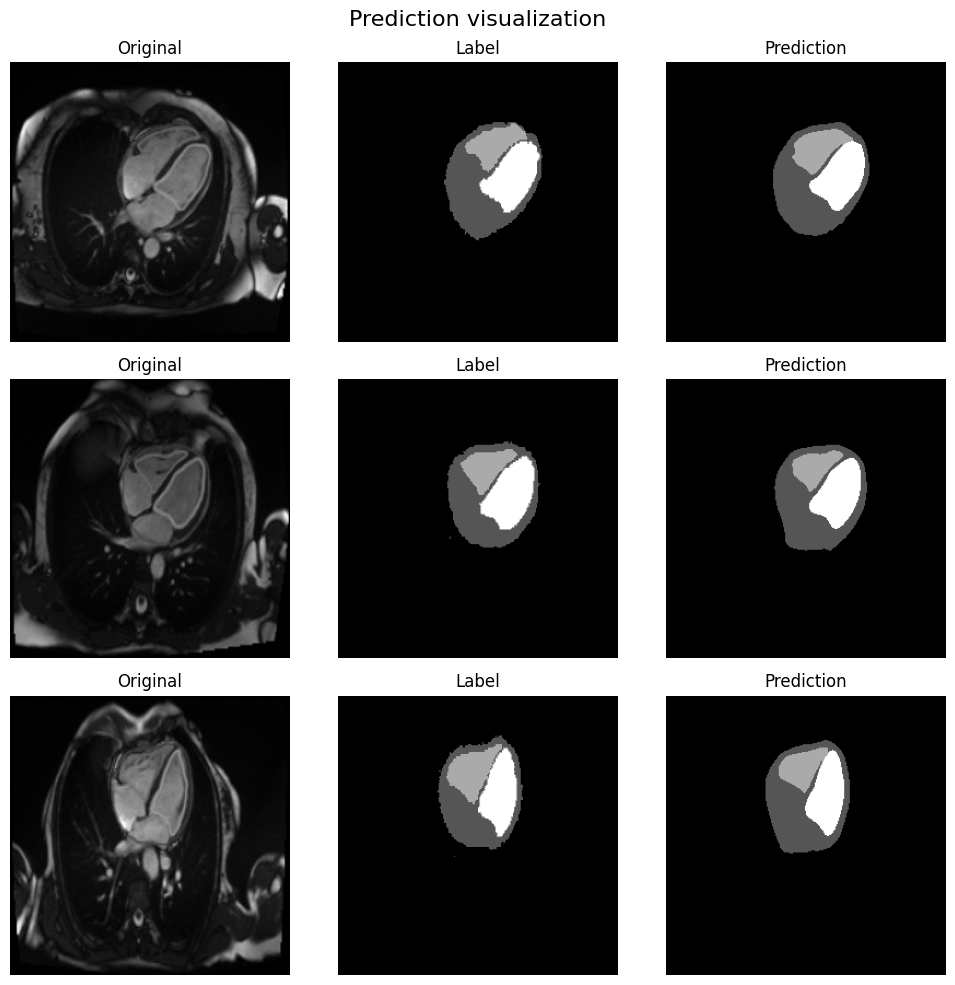

In [ ]:
# Convert 3 data from the test set to see how our model is performing
x= test_dataset[10][0].to(device)
x= x.unsqueeze(0)
outcome1 = model(x)
outcome1 = outcome1.to('cpu').detach()
outcome1 = torch.argmax(outcome1, 1)

x= test_dataset[15][0].to(device)
x= x.unsqueeze(0)
outcome2 = model(x)
outcome2 = outcome2.to('cpu').detach()
outcome2 = torch.argmax(outcome2, 1)

x= test_dataset[20][0].to(device)
x= x.unsqueeze(0)
outcome3 = model(x)
outcome3 = outcome3.to('cpu').detach()
outcome3 = torch.argmax(outcome3, 1)

titles = ["Original", "Label", "Prediction", "Original", "Label", "Prediction", "Original", "Label", "Prediction"]

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Plot arrays and set titles for each subplot
arrays = [test_dataset[10][0].squeeze(0), test_dataset[10][1].squeeze(0), outcome1[0],
          test_dataset[15][0].squeeze(0), test_dataset[15][1].squeeze(0), outcome2[0],
          test_dataset[20][0].squeeze(0), test_dataset[20][1].squeeze(0), outcome3[0]]
for i in range(3):
    for j in range(3):
        ax = axs[i, j]
        ax.imshow(arrays[i * 3 + j], cmap="gray")
        ax.set_title(titles[i * 3 + j])
        ax.axis("off")

fig.suptitle("Prediction visualization", fontsize=16)
plt.tight_layout()
plt.show()